# Extracting features from text file


See https://towardsdatascience.com/document-feature-extraction-and-classification-53f0e813d2d3

In [3]:
import spacy
import textacy

import numpy as np
from sklearn.feature_extraction import text
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
content = """That dirty tricks exist in the world of high-stakes politics will come as a surprise to few. Nonetheless, leaders of the global firm Cambridge Analytica captured headlines around the world this week as they breezily discussed the strategies for deception and manipulation of foreign elections on hidden cameras. Cambridge Analytica has been accused of improperly using information from more than 50 million Facebook accounts. The London-based company denies wrongdoing. Cambridge Analytica is best known for its work with Donald Trump's presidential election campaign in 2016. CEO Alexander Nix, unaware he was being recorded, claimed he'd met Trump "many times" in a bombshell undercover investigation broadcast Tuesday on Britain's Channel 4 news. A colleague also suggested they created damaging memes targeting Hillary Clinton during the election. Nix was suspended the day after the story aired. The investigation revealed that over the course of four meetings, the journalists used hidden cameras and microphones to record Nix and the company's managing director Mark Turnbull, as they discussed ways to secretly influence Sri Lanka's upcoming national election — something they claim they'd already done in Kenya in 2017."""

print(content)

In [ ]:
metadata = {'title': 'How Cambridge Analytica stumbled into the spotlight',
            'author': 'Diana Swain',
            'pub_date': '2018-03-24'}

## 1. Using spaCy and textaCy

In [ ]:
doc = textacy.Doc(content, metadata=metadata, lang='en')
print(doc)

In [ ]:
doc.to_bag_of_terms(ngrams=2, named_entities=False, lemmatize=True, 
                    as_strings=True)

In [ ]:
[i for i in textacy.extract.named_entities(doc)]

## 2. Using sklearn

In [4]:
# Load example dataset
categories = ['alt.atheism', 'soc.religion.christian',
              'comp.graphics', 'sci.med']

from sklearn.datasets import fetch_20newsgroups

twenty_train = fetch_20newsgroups(subset='train',
    categories=categories, shuffle=True, random_state=42)

In [ ]:
twenty_train.data[1]

In [ ]:
# Raw word counts
count_vect = text.CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts

In [ ]:
# tf-idf
tfidf_transformer = text.TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf

In [ ]:
fake_data = X_train_tfidf[:50, :].todense()
fake_data[:25, 0] = 0
fake_data[25:, 0] = 100
fake_data.shape

In [ ]:
# Run t-SNE
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99,
                  init='pca')

tsne_fit = tsne_model.fit_transform(fake_data)

In [ ]:
# Plot with seaborn

sns.regplot(x=tsne_fit[:, 0], y=tsne_fit[:, 1], fit_reg=False)

## Make function that automates the whole process

Input: list of strings (each element contains one article)
Output: array N x 2 containing t-SNE values, array containing labels for 

In [25]:
from sklearn.feature_extraction import text
from sklearn.manifold import TSNE


TSNE_ARGS = {'n_components': 2, 
             'verbose': 1, 
             'random_state':0, 
             'angle':.99,
             'init': 'pca'}


def fit_tsne_on_corpus(corpus, labels=None, tsne_args=TSNE_ARGS):
    """Fit t-SNE on a text corpus.
    
    Fit t-SNE on a text corpus.
    The following steps are used:
    1. Extract word count from each document of the corpus.
    2. Transform word counts into tf-idf feature vectors.
    3. (Optional) Add labels to the matrix.
    4. Run t-SNE.
    
    Args:
        corpus (list of str): list containing `n_docs` strings, where each 
            string is one document
    
    Keyword Args:
        labels (np.ndarray): labels to include when running t-SNE. Provided as
            array of shape (n_docs, n_labels) where each row contains the 
            labels for a specific document. Labels must be numerical values.  
        tsne_args (dict): dictionary of arguments to pass to sklearn's
            TSNE function.
        
    Returns:
        (np.ndarray): array of shape (n_docs, 2) containing the t-SNE 
            coordinates for each document
            
    TODO:
    - Extract better features than tf-idf
    - Allow modifying t-SNE's hyperparameters
    - Use different t-SNE backend for speed
    """
    
    assert isinstance(corpus, list)

    count_vect = text.CountVectorizer()
    counts = count_vect.fit_transform(corpus)
    
    tfidf_transformer = text.TfidfTransformer()
    tfidf_data = tfidf_transformer.fit_transform(counts).todense()
    
    if labels is not None:
        tfidf_data = np.concatenate([tfidf_data, labels], axis=1)

    tsne_model = TSNE(**tsne_args)
    tsne_coords = tsne_model.fit_transform(tfidf_data)
    
    return tsne_coords


def plot_coords(coords, labels=None):
    """Plot coordinates with optional labels.
    
    Args:
        coords (np.ndarray): array of shape (n_points, 2) containing the
            coordinates of each point.
            
    Keyword Args:
        labels (np.ndarray): array of shape (n_points,) containing a categorical
            label or each point.
    """
    
    if labels is None:
        labels = np.zeros((coords.shape[0], ))
                
    classes = np.unique(labels)
    cm = sns.color_palette('hls', len(classes))
    
    fig, ax = plt.subplots()
    
    for i, c in enumerate(classes):
        print('Class {}'.format(c))
        ind = labels == c
        ax.scatter(coords[ind, 0], coords[ind, 1], s=5, 
                   color=cm[i], label=c)
    ax.legend()
        
    plt.show()

In [6]:
fake_labels = np.zeros((50, 1))
fake_labels[25:, 0] = 1

coords = fit_tsne_on_corpus(twenty_train.data[:50], labels=fake_labels)

[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.000s...
[t-SNE] Computed neighbors for 50 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 0.615252
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.871647
[t-SNE] Error after 1000 iterations: 0.367086


Class 0.0
Class 1.0


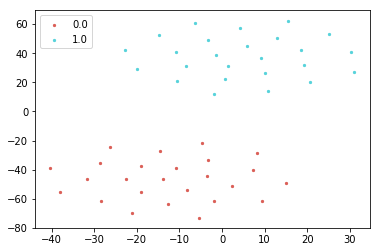

In [26]:
plot_coords(coords, labels=fake_labels.reshape(-1,))